# Imports <a id="imports"></a>

In [1]:
# general
import numpy as np
import tqdm
import math
from collections import defaultdict, namedtuple

# RL
import gym
import gym_sokoban
from stable_baselines3 import DQN
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.callbacks import StopTrainingOnRewardThreshold


# plotting
from IPython.display import display, Image
import matplotlib.pyplot as plt
import imageio

# Table of Contents <a id="toc"></a>

[Imports](#imports)

[Table of Contents](#toc)

1 [Introduction](#introduction)  
2 [Installation and Setup](#installation)  
&nbsp;&nbsp;&nbsp;&nbsp;2.1 [Software Versions](#versions)  
&nbsp;&nbsp;&nbsp;&nbsp;2.2 [Environment Setup](#setup)  
3 [Environment](#env)  
&nbsp;&nbsp;&nbsp;&nbsp;3.1 [Properties](#envproperties)  
&nbsp;&nbsp;&nbsp;&nbsp;3.2 [Visualization](#envviz)  
&nbsp;&nbsp;&nbsp;&nbsp;3.3 [Action Space](#actionspace)  
&nbsp;&nbsp;&nbsp;&nbsp;3.4 [Observation Space](#observationspace)  
&nbsp;&nbsp;&nbsp;&nbsp;3.5 [Reward Function](#rewardfunction)  
&nbsp;&nbsp;&nbsp;&nbsp;3.6 [Game Configuration](#gameconfiguration)  
&nbsp;&nbsp;&nbsp;&nbsp;3.7 [Level Generation](#levelgeneration)  
4 [Auxiliary Functions](#aux)  
&nbsp;&nbsp;&nbsp;&nbsp;4.1 [Custom Animation Functions](#customanimationfunction)  
&nbsp;&nbsp;&nbsp;&nbsp;4.2 [Algorithm Convergence](#algorithmconvergence)  
&nbsp;&nbsp;&nbsp;&nbsp;4.3 [State Space](#statespace)  
5 [Monte Carlo Off-Policy Control](#mc)  
&nbsp;&nbsp;&nbsp;&nbsp;5.1 [Implementation](#mcimplementation)  
&nbsp;&nbsp;&nbsp;&nbsp;5.2 [Experiments](#mcexperiments)  
&nbsp;&nbsp;&nbsp;&nbsp;5.3 [Discussion](#mcdiscussion)  
6 [Deep Q-Network](#dqn)  
&nbsp;&nbsp;&nbsp;&nbsp;6.1 [Experiments](#dqnexperiments)  
&nbsp;&nbsp;&nbsp;&nbsp;6.2 [Results](#dqnresults)  
7 [Conclusion](#conclusion)  


[References](#references)

# 1 Introduction
<a id="introduction"></a>

[🔝 Return to Table of Contents](#toc)

[Sokoban](https://en.wikipedia.org/wiki/Sokoban), which means [*warehouse keeper*](https://en.wikipedia.org/wiki/Sokoban#cite_note-1) in Japanese, is a puzzle video game set in a warehouse environment. The objective of the game is to push all the boxes in the warehouse to their designated storage locations/targets.

This setting can be seen as a useful analog for real-world problems. In an actual warehouse for example, robots are often used to transport goods from one location to another [[4]](#references). The problem of optimizing the movement of these robots can be formulated as a reinforcement learning problem, where the robots need to learn how to move the goods while minimizing the time and energy required. 

The [Sokoban environment](https://github.com/mpSchrader/gym-sokoban) provides a simplified version of this problem. The possibility of making irreversible mistakes makes these puzzles challenging especially for [Reinforcement Learning](https://en.wikipedia.org/wiki/Reinforcement_learning) algorithms.

<a id="examplegames"></a>

| Example Game 1 | Example Game 2 | Example Game 3 | Example Game 4 |
| :---: | :---: | :---: | :---: |
| ![Game 1](gym-sokoban/docs/Animations/solved_3.gif?raw=true) | ![Game 2](gym-sokoban/docs/Animations/solved_4.gif?raw=true) | ![Game 3](gym-sokoban/docs/Animations/solved_5.gif?raw=true) | <img src="gifs/basic_animation_3.gif" style="width:100%"> |

The [Sokoban environment](https://github.com/mpSchrader/gym-sokoban) for Python was implemented by [Max-Phillip Schrader](https://github.com/mpSchrader) based on the rules presented in [DeepMind's](https://www.deepmind.com/) paper "Imagination Augmented Agents for Deep Reinforcement Learning" [[3]](#references). In the paper, the room generation is random per default which allows training Deep Neural Networks without overfitting on a set of predefined rooms. The generalization ability of the agent is a key challenge DeepMind successfully overcame.

While this problem is [unreasonably hard](https://www.youtube.com/watch?v=xp-YOPcjkFw&t=168s) to tackle in a submission like this, the environment is still a good choice for testing and comparing Reinforcement Learning algorithms. 

Therefore, changes were made to the [Sokoban Environment](https://github.com/mpSchrader/gym-sokoban) that allow to repeatedly use the same room for multiple episodes. We'll focus on this problem for this submission.

# 2 Installation and Setup <a id="installation"></a>

[🔝 Return to Table of Contents](#toc)

## 2.1 Software Versions <a id="versions"></a>


This submission was tested using:
* `Windows` 10
* `python` 3.10.4


For the python modules, please refer to the provided `requirements.txt`. Other versions may work, but are not guaranteed to do so.

## 2.2 Environment Setup <a id="setup"></a>

❗ Only re-do below steps if you want to recreate the environment customization from scratch. The customized code should already be in the submitted `.zip` file; if so, skip to [2.2.3 Pip Installation](#pipinstall) to add the module via pip.

Note that some alterations may become more clear after reading [Chapter 3](#env). You might want to consider reading that first. We included this section at the top though, as it is the first step to get the environment running.

### 2.2.1 Downloading the Environment <a id="download"></a>


In your terminal, run the following commands to download the environment to your destination folder of choice:

```
git clone https://github.com/mpSchrader/gym-sokoban.git
```

### 2.2.2 Customization of the Environment <a id="customization"></a>

#### 2.2.2.1 `reset()`-Function <a id="reset"></a>

The following customization enables the `reset()` function to start the same level again. This is useful for various reasons, the simplest of which is to train a model repeatedly on the same level. We'll also default to the `keep=True` variant, as it is more useful for our purposes.


Navigate to `gym_sokoban/envs/sokoban_env.py` file and paste the following lines in place of the existing function:

```python
def reset(self, second_player=False, render_mode='raw', keep=True):
    try:
        if (not keep) or (not hasattr(self, 'tempSave')):
            self.tempSave = generate_room(
                dim=self.dim_room,
                num_steps=self.num_gen_steps,
                num_boxes=self.num_boxes,
                second_player=second_player
            )
            
        # generate deep copy of self.tempSave
        self.room_fixed = self.tempSave[0].copy()
        self.room_state = self.tempSave[1].copy()
        self.box_mapping = self.tempSave[2].copy()
        ...
```

Afterwards the code should look like this:

<figure>
<img src="./pictures/module_alteration_reset1.png" style="width:100%">
<figcaption align = "center"> Before / After </figcaption>
</figure>

Let's also change the default `render_mode` value to `'raw'` while we're at it. This will make the environment render in the same way as the `step()` function, as we'll explain below.

#### 2.2.2.2 `step()`-Function

Another alteration is made to the `step()` function of the module. In the original code, the `step()` function would take in an `observation_mode` as an argument. This argument would determine the type of observation that is returned by the function. 

However, the default value of this argument is `'rgb_array'` and changing it to any other value will result in an error. Why this is the case is not clear. 

```python
def step(self, action, observation_mode='rgb_array'):

    ...

    return observation, self.reward_last, done, info
```

🚧 Internally, the observation would be generated by transforming the underlying data structure used to represent the environment into an image. This would slow down the agent-environment interaction significantly, as the transformation would have to be done every time the `step()` function is called.

💡 To reduce unnecessary complexity as well as to improve runtime, we'll work with the `'raw'` observation mode internally and use the `'rgb_array'` mode for visualization purposes only. Therefore, we'll have to *hard-code* the following changes:

```python
def step(self, action, observation_mode='raw'):

    ...
```

Afterwards the code should look like this:

<figure>
<img src="./pictures/module_alteration5.png" style="width:100%">
<figcaption align = "center"> Before / After </figcaption>
</figure>

Furthermore, we'll have to adjust the module's observation space now that the default has changed. Paste the following lines in place of the original code:

```python
self.observation_space = gym.spaces.Box(
    low=0,
    high=255,
    shape=(4,)+(dim_room[0], dim_room[1]),
    dtype=float
)
```

Afterwards the code should look like this:

<figure>
<img src="./pictures/module_alteration_obsspace.png" style="width:100%">
<figcaption align = "center"> Before / After </figcaption>
</figure>

🚧 It is possible that these problems could be resolved by using an alternative combination of the used packages. However, to address these issues without wasting too much time, the alterations above were made.

#### 2.2.2.3 `render()`-Function

Further alterations have to be made inside the `render()` function. As both the `step()` and `reset()` functions internally call the `render()` function, we'll have to make sure that the `render()` function works properly.


Original code:

```python
def render(self, mode='human', close=None, scale=1):
    assert mode in RENDERING_MODES

    img = self.get_image(mode, scale)

    if 'rgb_array' in mode:
        return img

    elif 'human' in mode:
        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.SimpleImageViewer()
        self.viewer.imshow(img)
        return self.viewer.isopen
    
    elif 'raw' in mode:
        ...
```

As you can see, the `img`-object gets created regardless of the rendering mode. For the `'raw'` mode this would be idiotic, as the `img`-object would not be used and only slow down the runtime. Therefore, we'll have to move the `img`-object creation into the `if`/`elif`-block:

Customized code:

```python
def render(self, mode='human', close=None, scale=1):
    assert mode in RENDERING_MODES

    if 'rgb_array' in mode:
        img = self.get_image(mode, scale)
        return img

    elif 'human' in mode:
        img = self.get_image(mode, scale)
        from gym.envs.classic_control import rendering
        if self.viewer is None:
            self.viewer = rendering.SimpleImageViewer()
        self.viewer.imshow(img)
        return self.viewer.isopen

    elif 'raw' in mode:
        ...
```

Afterwards the code should look like this:

<figure>
<img src="./pictures/module_alteration.png" style="width:100%">
<figcaption align = "center"> Before / After </figcaption>
</figure>

#### 2.2.2.4 Results on the Runtime

All the alterations above combined, speed up the execution time of the `step()`-function, and therefore a large part of the training process, by a factor of ~100. Profiling the MC-Algorithm via the `cProfile` module and visualizing the results via `snakeviz`, shows that the original `step()`-function took up ~99% of the runtime.

Therefore, by first changing the `step()`-function to default to the `'raw'` observation mode, then by fixing the `render()`-function to only call `get_image()` when necessary, this improvement was achieved.

Below are the results of profiling before the alterations:

<figure>
<img src="pictures/snakeviz_before.png">
</figure>

And here are the results after the alterations:

<figure>
<img src="pictures/snakeviz_after.png">
</figure>

This was measured for running the [Monte Carlo Off-Policy Control](#mc) algorithm. In this setting, we increased the throughput from ~1 episodes/second to ~100 episodes/second. Note that this still is quite low for a rather naive implementation such as MC control, but it's a significant improvement nonetheless. 

### 2.2.3 Pip Installation <a id="pipinstall"></a>

Finally, after customizing the module, run the following commands in your terminal to install the environment:

```
cd gym-sokoban
pip install -e .
```

And restart your notebooks kernel.

# 3 Environment <a id="env"></a>

[🔝 Return to Table of Contents](#toc)

In [2]:
env = gym.make('Sokoban-v0') # create basic environment for illustrative purposes
_ = env.reset() # initial reset necessary to allow interaction with the environment

## 3.1 Properties <a id="envproperties"></a>

* `single agent`: in the default version there is only one agent operating in the environment. The agent is responsible for moving the boxes to their respective targets, and there are no other agents that it needs to coordinate with. There is a variant (cf. [3.6 Game Configuration](#gameconfiguration)) that allows for two agents to operate in the same environment, which then would be considered multi-agent, but this is not the default version.
  
* `fully observable`: the agent can observe the complete state of the environment at each point in time. The agent can see the location of all boxes, walls, and targets in the environment, and can use this information to plan its actions accordingly.
  
* `determinsitic`: the outcome of each action taken by the agent is completely determined by the state of the environment. There are no random events that can affect the state of the environment, and the agent can predict the outcome of its actions with certainty
  
* `episodic`: there is a clear terminal state that ends the episode. The agent can either solve the puzzle or run out of time. 
  
* `static`: the environment does not change while the agent is 'thinking'. The room is generated once and stays the same for the entire episode.
  
* `discrete action space`: the agent can only perform a limited set of actions, such as pushing a box or moving in a certain direction. The agent cannot take a continuous range of actions like moving at any arbitrary speed or direction. Thus, the action space is defined by a finite set of actions that the agent can take.
  
* `discrete state space`: although the room is generated randomly, the number of possible states in a room is finite, but large.

## 3.2 Visualization <a id="envviz"></a>

### 3.2.1 Room Elements <a id="roomelements"></a>

Every room consists of five main elements: walls, floor, boxes, box targets, and a player. They might have different states whether they overlap with a box target or not. 

| Type       | State      | TinyWorld | Graphic |
| ---        | -----      | :---: | :---: |
| Wall       | Static     | ![Wall](gym-sokoban/gym_sokoban/envs/surface/tiny_world/wall.png "Wall") | ![Wall](gym-sokoban/gym_sokoban/envs/surface/wall.png "Wall") |
| Floor      | Empty      | ![Floor](gym-sokoban/gym_sokoban/envs/surface/tiny_world/floor.png "Floor") | ![Floor](gym-sokoban/gym_sokoban/envs/surface/floor.png "Floor") |
| Box Target | Empty      | ![BoxTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/box_target.png "Box Target") | ![BoxTarget](gym-sokoban/gym_sokoban/envs/surface/box_target.png "Box Target") |
| Box        | Off Target | ![BoxOffTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/box.png "Box") | ![BoxOffTarget](gym-sokoban/gym_sokoban/envs/surface/box.png "Box") |
| Box        | On Target  | ![BoxOnTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/box_on_target.png "Box") | ![BoxOnTarget](gym-sokoban/gym_sokoban/envs/surface/box_on_target.png "Box") |
| Player     | Off Target | ![PlayerOffTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/player.png "Player") | ![PlayerOffTarget](gym-sokoban/gym_sokoban/envs/surface/player.png "Player") |
| Player     | On Target  | ![PlayerOnTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/player_on_target.png "Player") | ![PlayerOnTarget](gym-sokoban/gym_sokoban/envs/surface/player_on_target.png "Player") |

Throughout the project we will use the both representations of the room elements. The `TinyWorld` representation is useful as it less complex in its structure (cf. [3.2.2 Rendering](#roomrendering)) while the `Graphic` representation may be more intuitive.

Below are examples of a room visualized in the `TinyWorld` style. For illustrative purposes, the characteristic elements are annotated with their respective labels.

**Example 1**
<figure>
<img src="pictures/example_rooms_1.png" style="width:64%">
</figure>

When a player ![PlayerOffTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/player.png "Player") *moves* onto a box target field ![BoxTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/box_target.png "Box Target") the player's color changes to ![PlayerOnTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/player_on_target.png "Player")

**Example 2**

<figure>
<img src="pictures/rooms_2.png" style="width:100%">
</figure>

When a box ![BoxOffTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/box.png "Box") *gets pushed* onto a box target field ![BoxTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/box_target.png "Box Target") the box's color changes to ![BoxOnTarget](gym-sokoban/gym_sokoban/envs/surface/tiny_world/box_on_target.png "Box")

### 3.2.2 Rendering <a id="roomrendering"></a>

The current state of the environment can be visualized by calling the `env.render(mode='...')` function. 

Available rendering modes are:

| Mode | Description |
| ---  | --- 
| rgb_array | Well looking 2d rgb image
| tiny_rgb_array | Each pixel describing one element in the room
| human [🚧] | Displays the current state on screen
| tiny_human [🚧] | Displays the tiny rgb_array on screen

Each configuration can also be rendered as `TinyWorld`, which has a pixel size equal to the grid size and uses different icons (cf. [3.2.1 Room Elements](#roomelements)). To get an environment rendered as such just add `'tiny_'` in front of the rendering mode.

For rendering modes `'rgb_array'` and `'tiny_rgb_array'` the function `env.render()` returns a 3D-RGB `numpy` array of shape `(width, height, 3)` that can be displayed using `matplotlib` or other libraries. The third dimension of the array represents the RGB color channels of the image. The color of each pixel is determined by the type and state of the element at that position. 

The default (`'human'`) rendering mode internally uses the `pyglet` module to display the current state in a separate window on screen. Sadly, the original rendering function has problems for the  `'human'` rendering mode, which is why we implement our own, small rendering/wrapper function. Using the `matplotlib` module, the function renders the RGB values provided by the environment and displays them on screen.

In [3]:
# custom plotting function
def plot_env(img):
    plt.imshow(img)
    plt.axis('off')
    plt.show()

Calling this function with the 3D-array provided by the `'rgb_array'` rendering mode essentially achieves the same as `env.render('human')`. Furthermore, it acts a neat utility function that can also be called with the 3D-array provided by the `'tiny_rgb_array'` rendering mode. 

<figure>
<img src="pictures/rgb_array.png">
<img src="pictures/tiny_rgb_array.png">
<figcaption align = "center"> rgb_array / tiny_rgb_array </figcaption>
</figure>

🚧 It is possible that these problems could be resolved by using an alternative version of the `gym` package with `pyglet`. However, to address these issues without wasting too much time, the function described above was added.

## 3.3 Action Space <a id="actionspace"></a>

The game provides a total of nine actions to interact with the environment:

In [4]:
env.action_space

Discrete(9)

**Overview**

<figure>
<img src="pictures/mvmt.png" style="width:100%">
<figcaption align = "center"> Pushing actions / Moving actions </figcaption>
</figure>

**Details**


There is also the *No Operation* action, which is a void action. It does not change anything in the environment, altough one time step passes. This is probably useful for the multi-agent variation (cf. [3.6 Game Configuration](#gameconfiguration)).


| Action       | ID    |
| --------     | :---: |
| No Operation | 0     |

The four *Push*-Actions try to move an adjacent box if the next field behind the box is free. This means no chain-pushing of boxes is possible. In case there is no box at the adjacent field, the push action is handled the same way as the move action into the same direction.

| Action       | ID    |
| --------     | :---: |
| Push Up    | 1     |
| Push Down    | 2     |
| Push Left    | 3     |
| Push Right   | 4     |

The four *Move*-Actions simply moves if there is a free field in the direction, which means no blocking box or wall. In case there is a box or wall at the adjacent field the agent tries to move onto, the move action is *not* handled as a push action and will result in the agent staying in its state.


| Action       | ID    |
| --------     | :---: |
| Move Up      | 5     |
| Move Down    | 6     |
| Move Left    | 7     |
| Move Right   | 8     |

❗ This implementation leaves the question open why there even are move actions. The push actions could be used to move the player as well. However, the move actions are still available and can be used to move the player without moving a box. It is assumed that this is useful for the `Push&Pull` variant of the game, where the player can pull boxes as well (cf. [3.6 Game Configuration](#gameconfiguration)).

## 3.4 Observation Space <a id="observationspace"></a>

🚧 The default behavior of the `step()`-function has been slightly altered. For more information please refer to [2.2.2 Customization of the Environment](#customization).

The agent performs actions by calling the `env.step()` function, that takes in the action ID and returns:
* the next `observation` of the environment
* the respective `reward` of performing the action
* `done` flag indicating whether the episode is over
* some further `info` not relevant for the agent

In [5]:
observation, reward, done, info = env.step(0)
env.observation_space.shape

(4, 10, 10)

The [(default)](#customization) `observation` is a 4-tuple that consist of the following elements:

* wall placement
* target placement
* box placement
* player placement

where each of these 4 elements is a 2D numpy array of shape `(env_width, env_height)`.

In [6]:
arr_walls, arr_goals, arr_boxes, arr_player = observation

Array-elements with value `1` represent the *presence* of the respective element at the corresponding position. 

Items with value `0` represent the *absence* of the respective element at the corresponding position.

For example the walls in the grid:

In [7]:
print(arr_walls)

[[1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 0 1 1 1]
 [1 0 0 0 0 0 0 1 1 1]
 [1 0 0 0 0 0 0 0 1 1]
 [1 0 0 1 0 0 0 0 0 1]
 [1 1 0 1 1 1 1 1 1 1]
 [1 0 0 0 1 1 1 1 1 1]
 [1 0 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 1 1]]


Lets take a look at this through our plotting function:

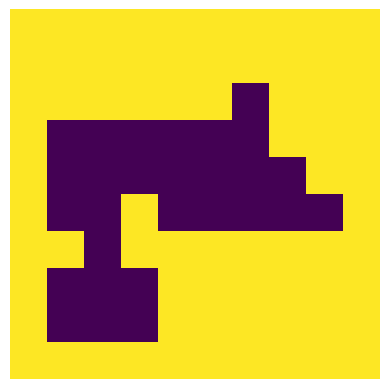

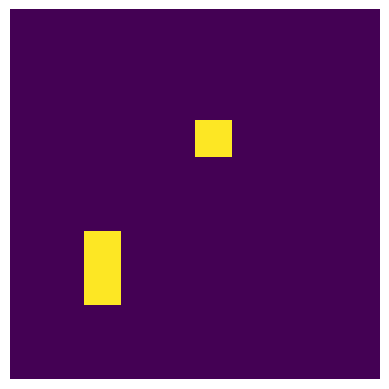

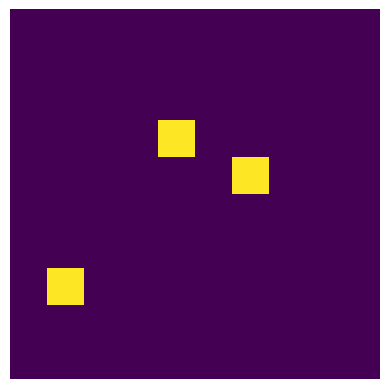

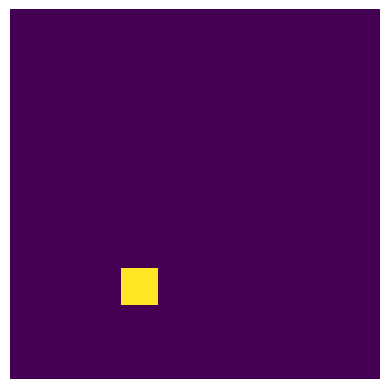

In [8]:
plot_env(arr_walls)
plot_env(arr_boxes)
plot_env(arr_goals)
plot_env(arr_player)

Let's layer the elements on top of each other to get a more visual understanding of the observation space:

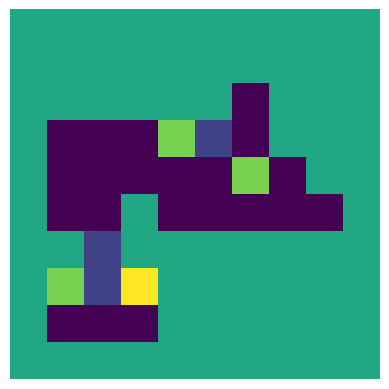

In [9]:
plot_env(arr_boxes+(arr_goals*4)+(arr_walls*3)+(arr_player*5)) # multiply by different numbers to make the different layers visible

This looks very similar to the `'tiny_rgb_array'` rendering mode, but its obtainment is much faster as it does not require the transformation of the underlying data structure into an image (cf. [2.2.2 Customization of the Environment](#customization)). 

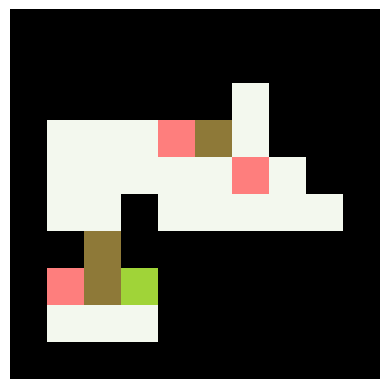

In [10]:
plot_env(env.render(mode='tiny_rgb_array'))

This representation holds the same amount of information as any other visualization mode. Hence, we'll use the `'tiny_rgb_array'`/`'rgb_array'` mode for visualization purposes only:

In [11]:
state = env.render(mode='rgb_array')
state.shape

(160, 160, 3)

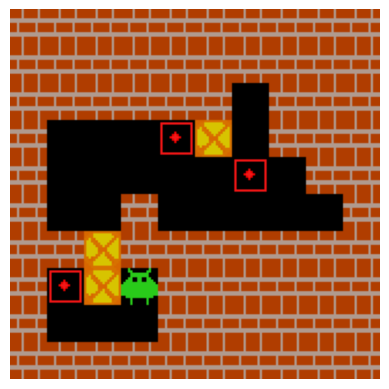

In [12]:
plot_env(state)

## 3.5 Reward Function <a id="rewardfunction"></a>

Finishing the game by pushing all boxes on the targets gives a reward of 10 in the last step. Furthermore, pushing a box on a target gives a reward of 1 and respectively pushing a box off a target of gives as reward of -1. This prevents reward farming by repeatedly pushing a box on and off a target. In addition, a reward of -0.1 is given for every step, this penalizes solutions with many steps.

| Reason                    | Reward |
| ------------------------- | ----:  |
| Perform Step              | -0.1   |
| Push Box on Target        |  1.0   |
| Push Box off Target       | -1.0   |
| Push all boxes on targets | 10.0   |

## 3.6 Game Configuration <a id="gameconfiguration"></a>

Sokoban has many different variations, such as Room Size, Number of Boxes or Rules.

### 3.6.1 Room Size <a id="roomsize"></a>

The available room configurations for the sokoban environment are shown in the table below:

| Room Id | Grid-Size | Pixels | #Boxes |
| --- | :---: | :---: | :---: | 
| Sokoban-v0 | 10x10 | 160x160 | 3 | 
| Sokoban-v1 | 10x10 | 160x160 | 4 | 
| Sokoban-v2 | 10x10 | 160x160 | 5 | 
| Sokoban-small-v0 | 7x7 | 112x112 | 2 |
| Sokoban-small-v1 | 7x7 | 112x112 | 3 | 
| Sokoban-large-v0 | 13x11 | 208x176 | 3 | 
| Sokoban-large-v1 | 13x11 | 208x176 | 4 | 
| Sokoban-large-v2 | 13x11 | 208x176 | 5 | 
| Sokoban-huge-v0 | 13x13 | 208x208 | 5 | 

Note that the larger rooms might take some time to be created, especially on a laptop. 

💡 For this submission we'll primarily focus on the default `Sokoban-v0` room configuration. If the scope of the project allows it, we may also look into some variations later on.

### 3.6.2 Gameplay & Rules <a id="gameplay"></a>

There are several variations of the Sokoban environment implemented in the `gym-sokoban` package, such as:

* `Fixed Targets`: Every box has to be pushed on the target with the same color.
* `Multiple Player`: There are two players in the room. Every round one of the two players can be used. There is no order of moves between the two players. 	
* `Push&Pull`: The player can not only push the boxes, but also pull them. Therefore, no more irreversible moves exist. 	
* `Boxoban`: Uses by DeepMind pregenerated Sokoban puzzles. This will especially be useful for testing the generalization ability of the agent as it provides preconfigured rooms with different difficulties.

For further information refer to the [original documentation](https://github.com/mpSchrader/gym-sokoban#253-other-variations).

💡 For this submission we'll primarily focus on the default version described in the sections above. If the scope of the project allows it, we may also look into some grid-size variations later on.

## 3.7 Level Generation <a id="levelgeneration"></a>

Every time a Sokoban environment is loaded or the `reset(keep=False)`-function called, a new room is randomly generated from scratch. For further information refer to the [original documentation](https://github.com/mpSchrader/gym-sokoban#24-level-generation).

# 4 Auxiliary Functions <a id="aux"></a>

[🔝 Return to Table of Contents](#toc)

Below we'll define some auxiliary functions that will be used throughout the project to easily do repetetive tasks.

## 4.1 Custom Animation Functions <a id="customanimationfunction"></a>

The following functions allow to create, store and display GIFs of the agent's performance; regardless of the rendering mode used. This is useful for visualizing the agent's performance throughout the report.

In [13]:
def create_gif(images, filename):
    """
    Creates a gif animation from a list of RGB images and stores it locally.

    Parameters:
    - images: a list of 3D numpy arrays representing RGB images
    - filename: the name of the output gif file
    - duration: the duration (in seconds) of each frame in the gif animation
    """
    # Normalize the image data to the range [0, 255]
    images = np.array(images)
    images = images.astype('uint8')

    # Create an imageio writer object for the output gif file
    writer = imageio.get_writer(filename, mode='I', duration=200)

    # Iterate over the images and add them to the writer object
    for i in range(images.shape[0]):
        image = images[i, :, :, :]
        writer.append_data(image)

    # Close the writer object
    writer.close()

In [14]:
# loads a gif animation from a filename and displays it in the notebook.
def display_gif(filename):
    with open(filename, 'rb') as f:
        display(Image(data=f.read(), format='gif'))

## 4.2 Algorithm Convergence <a id="algorithmconvergence"></a>

Below function provides a naive utility function to plot the algorithm's convergence. We'll use it later to visualize the performance of the agent during training.

In [15]:
def plot_convergence_curve(episode_lengths, episode_returns, unique_states):
    with plt.ioff():
        fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), facecolor='#292929')
        fig.patch.set_facecolor('#2B2B2B')

        # Plot 0: Episode length, smoothed over 100 episodes
        ax[0,0].set_facecolor('#2B2B2B')
        # ax[0,0].plot(episode_lengths, color='#01d000') # unsmoothed
        ax[0,0].plot(np.convolve(episode_lengths, np.ones((100,))/100, mode='valid'), color='#01d000')
        ax[0,0].set_xlabel('Episodes', fontsize=12, color='white')
        ax[0,0].tick_params(axis='x', colors='white')
        ax[0,0].tick_params(axis='y', colors='white')
        ax[0,0].spines['bottom'].set_color('white')
        ax[0,0].spines['left'].set_color('white')
        ax[0,0].set_title('Steps per episode', fontsize=14, color='white')


        # Plot 1: calc Cumulative Returns from episode_returns
        ax[1,0].set_facecolor('#2B2B2B')
        ax[1,0].plot(np.cumsum(episode_returns), color='#fc4f30')
        ax[1,0].set_xlabel('Episodes', fontsize=12, color='white')
        ax[1,0].tick_params(axis='x', colors='white')
        ax[1,0].tick_params(axis='y', colors='white')
        ax[1,0].spines['bottom'].set_color('white')
        ax[1,0].spines['left'].set_color('white')
        ax[1,0].set_title('Cumulative Episode Returns', fontsize=14, color='white')

        # Plot 2: Unique States Visited
        ax[0,1].set_facecolor('#2B2B2B')
        ax[0,1].plot(unique_states, color='#ff7f00')
        ax[0,1].set_xlabel('Episodes', fontsize=12, color='white')
        ax[0,1].tick_params(axis='x', colors='white')
        ax[0,1].tick_params(axis='y', colors='white')
        ax[0,1].spines['bottom'].set_color('white')
        ax[0,1].spines['left'].set_color('white')
        ax[0,1].set_title('Unique States', fontsize=14, color='white')

        # Plot 3: Mean Episode Returns, smoothed over 100 episodes
        ax[1,1].set_facecolor('#2B2B2B')
        ax[1,1].plot(np.convolve(episode_returns, np.ones((100,))/100, mode='valid'), color='#984ea3')
        ax[1,1].set_xlabel('Episodes', fontsize=12, color='white')
        ax[1,1].tick_params(axis='x', colors='white')
        ax[1,1].tick_params(axis='y', colors='white')
        ax[1,1].spines['bottom'].set_color('white')
        ax[1,1].spines['left'].set_color('white')
        ax[1,1].set_title('Mean Episode Returns', fontsize=14, color='white')

        plt.tight_layout()
    return plt

Note that although the function may not appear very often throughout the report, it was frequently used to debug the algorithms and to get a better understanding of their behavior.

## 4.3 State Space <a id="statespace"></a>

Consider a random room from the standard `Sokoban-v0` environment. To calculate the combinatorial possibilities of arranging $1$ player, $3$ identical boxes, and $26$ identical floor tiles, we need to consider the *total number of items* and the *number of each item type*.

The total number of items is the sum of the item type counts:
$$\text{total items} = 1 \text{ player} + 3 \text{ boxes} + 26 \text{ floor tiles}$$

💡 Note that box-targets are technically just regular floor tiles, as they can be either empty, occupied by a player or a box. 

To calculate the number of arrangements, we can use the concept of *permutations of multisets*. Since the boxes are identical, the arrangements of the boxes themselves do not contribute to different possibilities. Furthermore, we know that the floor tiles are also identical and cannot be distinguished from one another. Therefore, the number of arrangements can be calculated like this:

$$\frac{30!}{1! * 3! * 26!}$$

Or, more generally. if the multiplicities of the elements of a finite multiset $M$ (taken in some order) are $m_{1}, m_{2}, ..., m_{l}$ and their sum (that is, the size of $M$) is $n$, then the number of multiset permutations of $M$ is given by the multinomial coefficient [[2]](#references):

$$
  {n \choose m_1, m_2, \ldots, m_l} =
  \frac{n!}{m_1!\, m_2!\, \cdots\, m_l!} =
  \frac{\left(\sum_{i=1}^l{m_i}\right)!}{\prod_{i=1}^l{m_i!}}.
$$

For Sokoban, the room size, box amount and even player amount can vary (cf. [3.6 Game Configuration](#gameconfiguration)). So let's define a function that calculates the state space given an arbitrary environment to find out how many possible states there are.

In [16]:
def calculate_state_space(env_or_obs, keep=True):
    # allow for both env and observation as input
    if isinstance(env_or_obs, gym.Env):
        arr_walls, arr_goals, arr_boxes, arr_player = env_or_obs.reset(keep=keep)
    else:
        arr_walls, arr_goals, arr_boxes, arr_player = env_or_obs

    mean_room_size = int(np.sum((arr_walls-1)*-1))
    boxes = int(np.sum(arr_boxes))
    players = int(np.sum(arr_player))
    floor = mean_room_size-boxes-players
    state_amount = math.factorial(mean_room_size) / (math.factorial(players) * math.factorial(boxes) * math.factorial(floor))
    return int(state_amount)

# 5 Monte Carlo Off-Policy Control <a id="mc"></a>

[🔝 Return to Table of Contents](#toc)

Monte Carlo (MC) Off-Policy Control is a technique used to learn optimal policies by estimating action values based on sampled episodes. It operates in an off-policy setting, meaning the agent learns from interactions generated by a different policy than the one being evaluated or improved. Let's take a look at the key characteristics and assumptions of the algorithm:


1. State Space: The state space should consist of a finite number of distinct states. Each state represents a particular configuration or observation of the environment. For this section, we assume the Sokoban problem to have a finite state space.\
\
❗ But, due to the fact that not only the player but also the boxes can be moved, we are dealing with a very large state space! \
\
Especially, compared to other environments that can be reliably solved by the MC Off-Policy Control Algorithm. For example [FrozenLake](https://gymnasium.farama.org/environments/toy_text/frozen_lake/) has state space of $16$ in the default $4\times4$ grid, or $64$ in the big $8\times8$ grid. There, individual states are represented solely as the tile the player stands on, as opposed to our environment, where due to the moving boxes the entire room configuration represents the state. 

In [17]:
env = gym.make('Sokoban-v0')
state_amount = []
# average over 10 rooms
for i in range(10):
    state_amount.append(calculate_state_space(env, keep=False))
print("AVG State Space: ", np.mean(state_amount))

AVG State Space:  76669.2


With a number this large, many episodes will be necessary to consistently solve a room. Note that this could be considered as quasi-continuous state space.

2. Action Space: Similarly, the action space is also assumed to be finite, consisting of a fixed set of available actions that the agent can choose from in each state. The Sokoban environment most definitely has a finite action space (cf. [3.3 Action Space](#actionspace)). In this section, we're also limiting the agent to the four *push* actions, as they translate to *move* actions if there is no box to push. This is done to reduce unnecessary complexity.
   
3. Tabular Representation: Monte Carlo off-policy control assumes a tabular representation of the value function. This means that each state-action pair has a separate entry in the value function table, allowing for direct lookup and update.

4. Episode Sampling: During the episode sampling phase, the agent interacts with the environment by taking actions based on the behavior policy. The episodes are sampled until a termination condition is met, typically when a terminal state is reached. In the Sokoban environment, this means that the agent will continue to take actions until the room is solved (all boxes on targets) or the maximum number of steps is reached.

5. Incremental Updates: At the end of each episode, the action values in the value function table are updated incrementally based on the observed returns. This means that the new value is computed as a weighted average of the existing value and the observed return, with the weights depending on the number of times the state-action pair has been visited.


💡 These characteristics make Monte Carlo off-policy control suitable for problems with small and discrete state and action spaces. However, when dealing with large or continuous state spaces, as we are doing here, function approximation techniques such as deep neural networks are often used to approximate the action values instead of tabular representations.

## 5.1 Implementation <a id="mcimplementation"></a>

The MC algorithm [implemented below](#mcimplementation) is based on the pseudocode:

<figure>
<img src="./pictures/mcoffpolicycontrolalgo1.png" style="width:60%">
</figure>

that was presented in the book "Reinforcement Learning: An Introduction" by R. Sutton and A. Barto [[5, p. 91-111]](#references). 

### 5.1.1 Helper Function

This function maps each room configuration to a unique integer. This is useful for properly storing the action values with respect to the room configuration.

In [18]:
def map_observation_to_int(obs, state_dict):
    arr_walls, arr_goals, arr_boxes, arr_player = obs
    entry = arr_walls+(arr_goals*2)+(arr_boxes*3)+(arr_player*4)
    entry = entry.tobytes()
    
    if entry not in state_dict:
        state_dict[entry] = len(state_dict) # byte representation of room state => state_int
    return state_dict[entry]

### 5.1.2 Behavior Policy Function

This function represents our behavior policy `b`. It takes in the current state (as unique integer) and returns an action based on the probabilities assigned to each action. We've implemented the $\epsilon$-greedy policy, which selects a random action with probability $\epsilon$ and the greedy action with probability $1-\epsilon$.

In [19]:
def sample_epsilon_greedy_from_q(q, epsilon, state_int, nr_actions):
    if epsilon >= np.random.rand(): 
        # random suboptimal action
        return np.random.choice(np.arange(nr_actions))
    else: 
        # best/greedy action according to q-value
        return np.argmax(q[state_int])

### 5.1.3 MC Algorithm

Here is the core of the Monte Carlo off-policy control algorithm. The high-level steps can be summarized as follows:

1. Initialization: Initialize the value function `q` arbitrarily and create an empty table `c` to store the cumulative sum and count of returns for each state-action pair.

2. Behavior Policy: Select a behavior policy `b`, which determines the agent's actions during the exploration phase. This policy generates episodes by selecting actions based on probabilities assigned to each action.

3. Target Policy: Define a target policy `π` that the agent seeks to improve. This is typically a deterministic policy or a greedy policy based on the current action-value estimates.

`Repeat`: Iterate steps 4 to 7 until the action values converge to their optimal values or reach a predefined stopping criterion:

4. Episode Sampling: Generate episodes by interacting with the environment using the behavior policy. Each episode consists of a sequence of $〈s_t,a_t,r_{t+1}〉$ entries.

5. Update Returns: For each visited state-action pair in an episode, update the cumulative sum of returns by adding the observed rewards from that point onward.

6. Update Action Values: Estimate action values by calculating the average return for each state-action pair based on the sampled episodes. Update the value function using incremental updates, where the action values are updated incrementally based on the observed returns.

7. Policy Improvement: Update the target policy based on the improved action values. This can be done by selecting the action with the highest estimated value for each state (`greedy`).

In [20]:
def MCOffPolicyControl(env, epsilon=0.1, nr_episodes=5000, max_t=1000, gamma=0.99):
    """
    MC-based off-policy control using weighted importance sampling
    """

    actions = [1, 2, 3, 4] # push box actions
    nr_actions = len(actions)
    
    state_dict = defaultdict(lambda: int)

    # initialize q arbitrarily, but very small to ensure good exploration (during implementation this range was found to be helpful for quicker convergence)
    q = defaultdict(lambda: np.random.random((nr_actions)) * 0.01)
    c = defaultdict(lambda: np.full((nr_actions), 0.0, dtype=np.float32)) # initialize cumulative sum of WIS weights with 0
    pi = {}

    SAR = namedtuple('SAR', ['state', 'action', 'reward'])
    
    # custom lists for plotting epsiode return
    episode_returns = []
    episode_lengths = []
    unique_states = []

    with tqdm.trange(nr_episodes, desc='Training', unit='ep') as tepisodes:
        for e in tepisodes:
            # generate trajectory
            trajectory = []
            state = env.reset(keep=True)
            
            # epsilon decay, uncomment to use
            # epsilon = epsilon * 0.9995

            for t in range(max_t):
                # sample action from behaviour policy
                state_int = map_observation_to_int(state, state_dict)
                action = sample_epsilon_greedy_from_q(q, epsilon, state_int, nr_actions) # sample action
                # perform action and observe reward and next state
                obs, reward, done, _ = env.step(action+1) # add 1 to action to match the action space of the environment
                trajectory.append(SAR(state_int, action, reward)) # save the trajectory as Q-tuples
                state = obs

                # stop sampling when terminal state is reached
                if done: 
                    break 
            
            # compute episode reward and plotting metrics
            discounts = [gamma ** i for i in range(len(trajectory) + 1)]
            R = sum([a * b for a, (_, _, b) in zip(discounts, trajectory)])
            episode_returns.append(R)
            episode_lengths.append(len(trajectory))
            unique_states.append(len(state_dict))

            # update q-values from trajectory
            g = 0 # running return
            w = 1 # running importance sampling ratio
            for state, action, reward_i in reversed(trajectory):
                g = gamma*g + reward_i # update return
                c[state][action] = c[state][action] + w # update cumulative sum of WIS weights
                q[state][action] = q[state][action] + w/c[state][action] * (g - q[state][action]) # update q
                pi[state] = np.argmax(q[state]) # update target policy
                
                # stop updating if the target policy is not the greedy policy
                if pi[state] != action:
                    break
                
                w = w*(1/(1-epsilon+(epsilon/nr_actions))) # update WIS weight
            
            # print average return of the last 100 episodes
            if(e % 100 == 0):
                avg_return = np.mean(episode_returns[-100:])
                avg_length = np.mean(episode_lengths[-100:])
                tepisodes.set_postfix({
                'ep return': "{:.2f}".format(avg_return),
                'ep length': "{:3.2f}".format(avg_length),
                'ε': "{:3.2f}".format(epsilon)
                })

    # generating the convergence curve and other plots
    plt = plot_convergence_curve(episode_lengths, episode_returns, unique_states)
    return plt, {state: np.argmax(action_values) for state, action_values in q.items()}, state_dict    

### 5.1.4 Evaluation Function

To evaluate the learned target policy, we can use the `greedy` policy to select the best actions in each state. The function below takes in the learned target policy of the `MCOffPolicyControl` algorithm and runs it against the environment for a given number of episodes. It returns the average reward per episode as well as images of the last run to create a `.gif` file of the agent's performance.

In [21]:
def evaluate_greedy_policy(env, policy, state_dict, nr_episodes=1, t_max=100):
    reward_sums = []
    
    for t in range(nr_episodes):
        rewards = []
        
        state = env.reset(keep=True)

        if t == nr_episodes-1:
            images = []
            images.append(env.render(mode='rgb_array')) # capture initial state
        
        for i in range(t_max):
            # perform greedy action
            state_int = map_observation_to_int(state, state_dict)
            action = policy[state_int]
            state, reward, done, _ = env.step(action+1)
            rewards.append(reward)
            
            # only capture images in last episode
            if t == nr_episodes-1:
                images.append(env.render(mode='rgb_array'))
            
            if done:
                break

        reward_sums.append(np.sum(rewards))
        
    return np.mean(reward_sums), images

## 5.2 Experiments <a id="mcexperiments"></a>

### 5.2.1 Overview

Let's define the parameters for our first run:

In [22]:
# parameters
epsilon = 0.25
nr_episodes = 5_000
max_t = 150 # env organically caps episodes at 200 steps
gamma = 0.99

In [23]:
env = gym.make('Sokoban-v0')
_ = env.reset(keep=False)

plt, MC_policy, state_dict = MCOffPolicyControl(env, epsilon, nr_episodes, max_t, gamma)

Training: 100%|██████████| 5000/5000 [00:59<00:00, 84.18ep/s, ep return=-7.68, ep length=150.00, ε=0.25]


In [24]:
r, images = evaluate_greedy_policy(env, MC_policy, state_dict, 10, max_t)
print("Mean episode reward from MC trained policy: ", r)

Mean episode reward from MC trained policy:  -14.999999999999996


In [25]:
file = 'gifs/temp.gif'
create_gif(images, file)

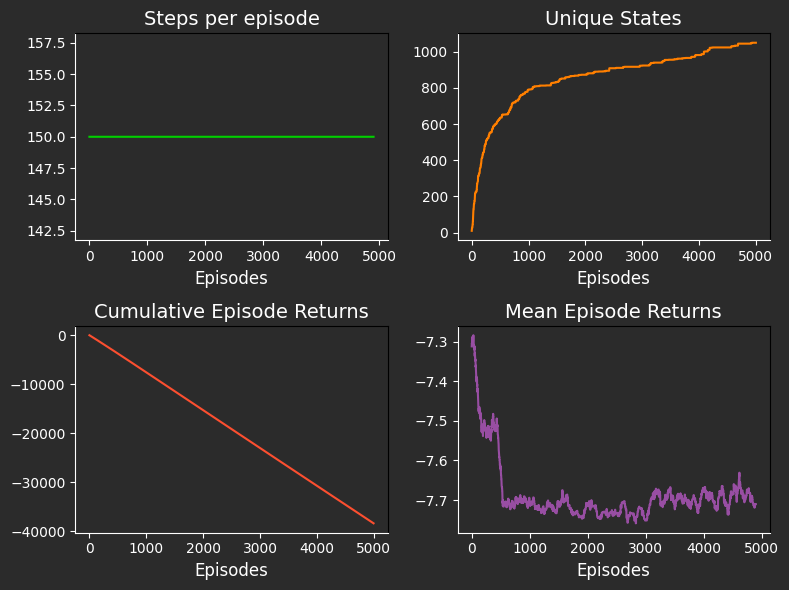

In [26]:
plt.show()

Now depending on whether we got lucky with the generated room, the agent may or may not be able to solve it. *Although it probably won't*. Feel free to rerun above cell until you get a solvable room.

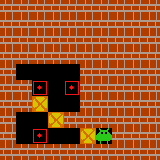

In [27]:
display_gif(file)

With only 5.000 episodes the agent is not able to solve the room. However, it is probably, depending on your random run, able to push one box on a target, which is a good start. Let's look at an agent that was able to successfully solve the randomly generated room, in case you were not so lucky:

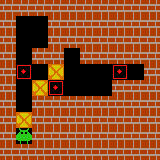

In [28]:
with open("./gifs/convergence_example_1.gif", 'rb') as f:
    display(Image(data=f.read(), format='gif'))

We can see that the agent pretty quickly learned to solve the environment. It kept exploring different states even after finding the solution, which is why the reward is not constant. This is due to the $\epsilon$-greedy policy, which keeps exploring with probability $\epsilon$.

This can either find a better solution or just be a waste of time.  However, this is not a problem as the agent will eventually converge to the optimal policy.

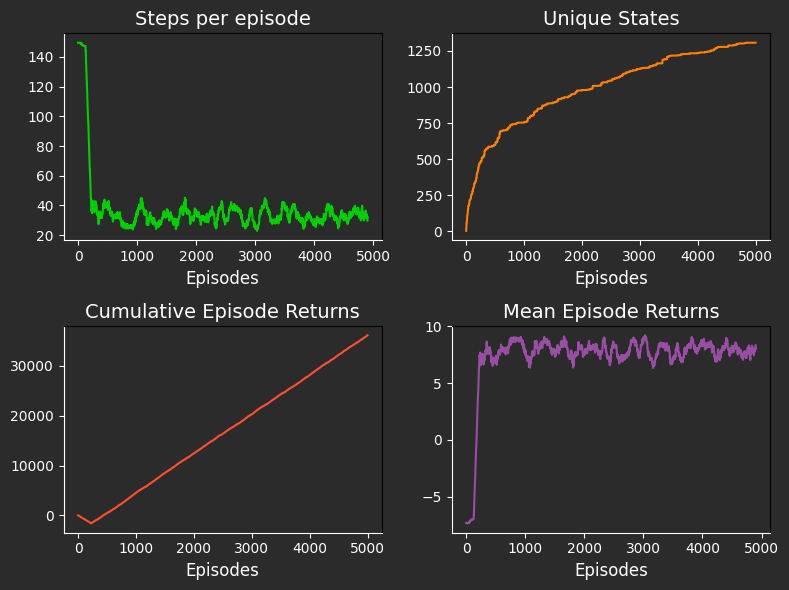

In [29]:
with open("./gifs/convergence_example1.png", 'rb') as f:
    display(Image(data=f.read(), format='png'))

### 5.2.2 5k Episodes

To make things more comparable, we ran the algorithm with the same parameters on 300 different rooms with 5k episodes per room. These runs are independent of another, we're simply interested how many it is able to solve.

#### 5.2.2.1 Sokoban-v0

We'll start with the same, $10\times10$ room configuration as above. For convenience these tests are not included in the report; we'll just take a look at the results.

In [30]:
returns = np.load('./data/logs/MC_experiments/MC_regular_returns_300_avg_5k_eps.npy')
envs = np.load('./data/logs/MC_experiments/MC_regular_envs_300_avg_5k_eps.npy')

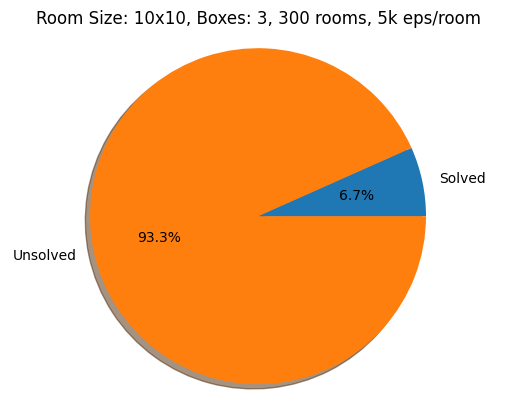

In [31]:
# pie chart of returns>0
labels = 'Solved', 'Unsolved'
sizes = [len(returns[returns>0]), len(returns[returns<0])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Room Size: 10x10, Boxes: 3, 300 rooms, 5k eps/room')
plt.show()

For this $10\times10$ room, it is able to solve about ~7% of the rooms. This is not a good performance, but it's a start. 

Let's compare the returns against the state space:

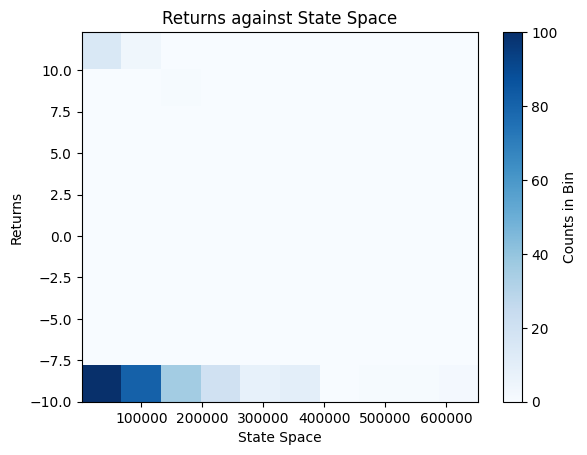

In [32]:
# Plot the returns against the state space of the environment
state_amount = [calculate_state_space(env, keep=False) for env in envs]
plt.hist2d(state_amount, returns, bins=10, cmap='Blues', vmin=0, vmax=100)
plt.title('Returns against State Space')
plt.xlabel('State Space')
plt.ylabel('Returns')
cb = plt.colorbar()
cb.set_label('Counts in Bin')
plt.show()

We can clearly see, when the agent is able to solve the room, it had a low state space. But there are enough rooms, where the agent is not able to solve the room, even though the state space is relatively low.

#### 5.2.2.2 Sokoban-small-v0

Let's see if it does better on smaller rooms. The `Sokoban-small-v0` room is only a $7\times7$ grid and only has $2$ boxes to move onto their targets (cf. [3.6 Game Configuration](#gameconfiguration)). Its state space is substantially smaller than the big, $10\times10$ room, but still quite high:

In [33]:
env = gym.make("Sokoban-small-v0")
state_amount = []
for i in range(100):
    state_amount.append(calculate_state_space(env, keep=False))
print("AVG State Space: ", np.mean(state_amount))

[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
[SOKOBAN] Runtime Error/Warning: Generated Model with score == 0
[SOKOBAN] Retry . . .
AVG State Space:  1754.16


This should improve our performance if the hypothesis, that the high state space is causing problems, holds true. 

Let's look at the results:

In [34]:
returns1 = np.load('./data/logs/MC_experiments/MC_small_returns_300_avg_5k_eps.npy')
envs1 = np.load('./data/logs/MC_experiments/MC_small_envs_300_avg_5k_eps.npy')

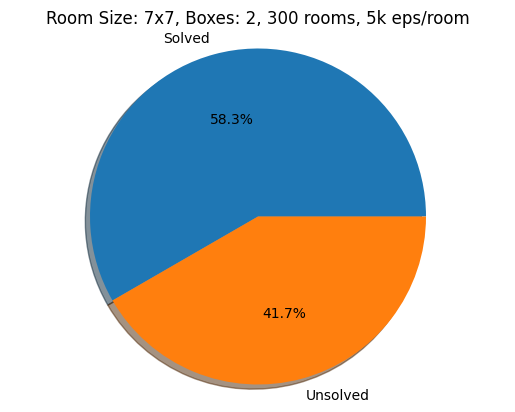

In [35]:
# pie chart of returns>0
labels = 'Solved', 'Unsolved'
sizes1 = [len(returns1[returns1>0]), len(returns1[returns1<0])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes1, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Room Size: 7x7, Boxes: 2, 300 rooms, 5k eps/room')
plt.show()

As we can clearly see, the agent is able to solve the smaller rooms more easily. Let's plot the returns against the state space as before:

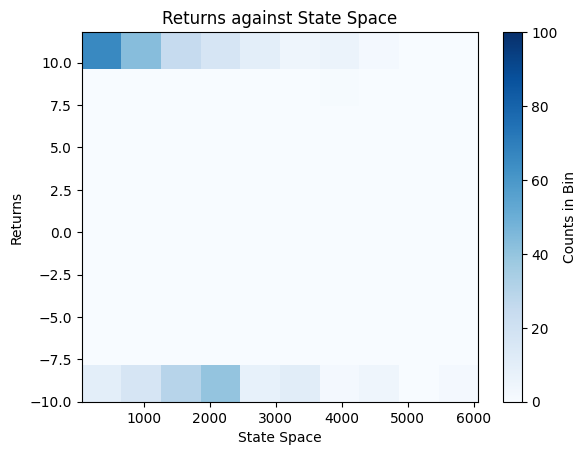

In [36]:
# create histogram of returns against state space
state_amount1 = [calculate_state_space(env, keep=False) for env in envs1]
plt.hist2d(state_amount1, returns1, bins=10, cmap='Blues', vmin=0, vmax=100)
plt.title('Returns against State Space')
plt.xlabel('State Space')
plt.ylabel('Returns')
cb = plt.colorbar()
cb.set_label('Counts in Bin')
plt.show()

Here, the relationship between state space and return becomes even clearer. The clear majority of the rooms solved, were in lower state space.

### 5.2.3 100k Episodes

Before, we trained our agent on 5.000 episodes per room. Let's see if we can improve the performance by training it on more episodes instead. For this we ran the agent only on 30 different rooms (due to increased computation effort) but for 100.000 episodes per room:

#### 5.2.3.1 Sokoban-v0

In [37]:
returns2 = np.load('./data/logs/MC_experiments/MC_regular_returns_30_avg_100k_eps.npy')
envs2 = np.load('./data/logs/MC_experiments/MC_regular_envs_30_avg_100k_eps.npy')

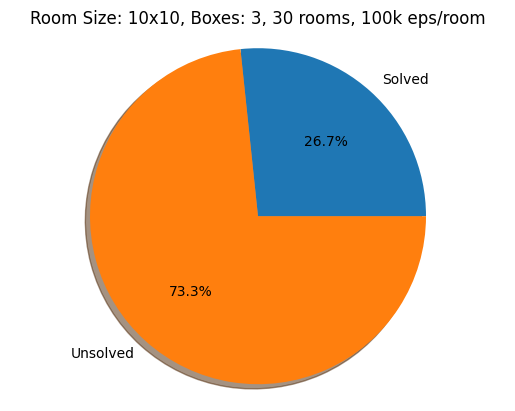

In [38]:
# pie chart of returns>0
sizes2 = [len(returns2[returns2>0]), len(returns2[returns2<0])]
fig1, ax1 = plt.subplots()
ax1.pie(sizes2, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Room Size: 10x10, Boxes: 3, 30 rooms, 100k eps/room')
plt.show()

For the bigger, $10\times10$ room, the agent is now able to solve about ~27% of the rooms. This is quite an improvement over the 5k episodes (~7%), but still not a good performance.

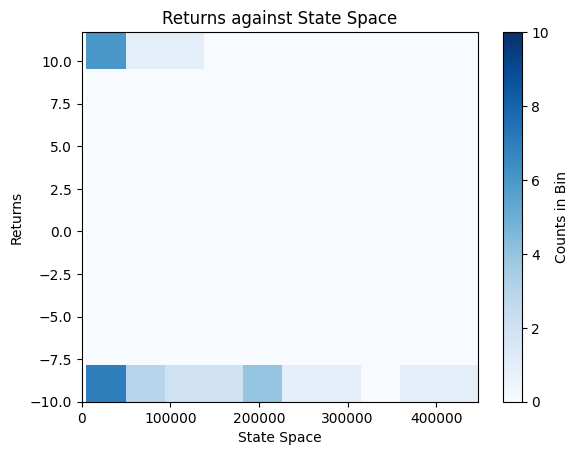

In [39]:
# Plot the returns against the state space of the environment
state_amount2 = [calculate_state_space(env, keep=False) for env in envs2]
# create histogram of returns against state space
plt.hist2d(state_amount2, returns2, bins=10, cmap='Blues', vmin=0, vmax=10)
plt.title('Returns against State Space')
plt.xlabel('State Space')
plt.xticks(np.arange(0, max(state_amount2)+1, 100000.0))
plt.ylabel('Returns')
cb = plt.colorbar()
cb.set_label('Counts in Bin')
plt.show()

Unsurprisingly, the agent again is only able to solve the rooms with low state space.

#### 5.2.3.2 Sokoban-small-v0

Let's see how much better the agent performs on the smaller rooms with 100k episodes:

In [40]:
returns3 = np.load('./data/logs/MC_experiments/MC_small_returns_30_avg_100k_eps.npy')
envs3 = np.load('./data/logs/MC_experiments/MC_small_envs_30_avg_100k_eps.npy')

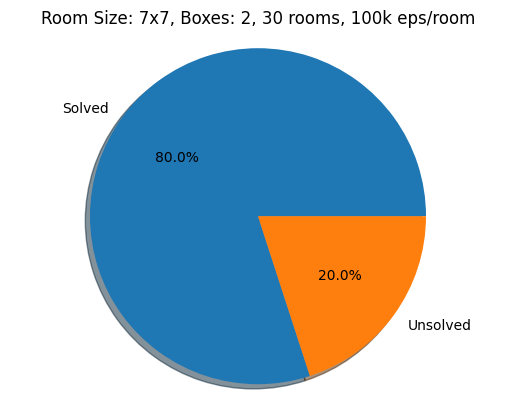

In [41]:
# pie chart of returns>0
labels = 'Solved', 'Unsolved'
sizes3 = [len(returns3[returns3>0]), len(returns3[returns3<0])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes3, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Room Size: 7x7, Boxes: 2, 30 rooms, 100k eps/room')
plt.show()

For the smaller, $7\times7$ rooms, the agent is able to solve whopping 80% of the rooms after 100.000 episodes!

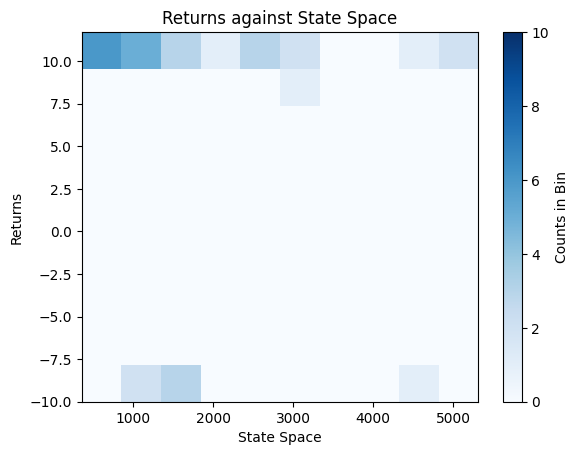

In [42]:
# create histogram of returns against state space
state_amount3 = [calculate_state_space(env, keep=False) for env in envs3]
plt.hist2d(state_amount3, returns3, bins=10, cmap='Blues', vmin=0, vmax=10)
plt.title('Returns against State Space')
plt.xlabel('State Space')
plt.ylabel('Returns')
# add legend, uniform colorbar
cb = plt.colorbar()
cb.set_label('Counts in Bin')
plt.show()

With more episodes to train on, we can see that the agent is able to solve rooms with higher state space as well.

## 5.3 Discussion <a id="mcdiscussion"></a>

We can clearly see that the MC algorithm is only able to learn the optimal policy for a fraction of the rooms generated by the Sokoban environment. We suspect that this is due to the very large state space of the Sokoban environment, as for smaller room configurations ($7\times7$) the algorithm is able to learn the optimal policy more often, but for larger rooms ($10\times10$) it fails to do so. 

% of rooms solved:
| environment | MC 5k | MC 100k |
|------------|-------|--------|
| `Sokoban-small-v0`   | 58.3% | 80%  |
| `Sokoban-v0` |  6.7% | 26.7%  |




This is not that surprising, considering that the MC algorithm is designed for small and discrete state spaces. But, running more episodes per room clearly improves the performance of the agent, as the agent has more time to explore the environment and learn the optimal policy. However, this comes at the cost of increased computation time.

In the following chapters we'll try to improve the performance of the agent by using more sophisticated algorithms that are able to handle large and continuous state spaces.

# 6 Deep Q-Network <a id="dqn"></a>

[🔝 Return to Table of Contents](#toc)

In this section, we'll look at the Deep Q-Network (DQN) algorithm, which is a deep reinforcement learning algorithm that combines the Q-learning algorithm with deep neural networks to learn the action-value function. It is an off-policy algorithm that uses a replay buffer to store and sample transitions, which are then used to update the action values. For more information on the DQN algorithm, refer to the [original paper](https://arxiv.org/pdf/1312.5602.pdf) by Mnih et al. [[6]](#references).

We'll import the `DQN` class from the `stable_baselines3` module and not code it ourselves. On the one hand, this is because the implementation of the DQN algorithm is quite complex and we want to focus on the results rather than the implementation details. On the other hand, the `stable_baselines3` module is a well-tested and reliable implementation of the DQN algorithm. Comparable implementations for MC off-policy control were not available at the time of this submisison.

## 6.1 Experiments <a id="dqnexperiments"></a>

Let's repeat our previous experiments (cf. [5.2 Experiments](#mcexperiments)) for the DQN algorithm. We'll try to use the same parameters as before to stay consistent. Unfortunately the experiments with 100k episodes per room are not included in the report, as they took too long to run. We'll instead look at the results of the 5k episodes per room experiments.

❗ When training the MC agents, we limited them to the 4 necessary **push** actions. Unfortunately, when running the DQN algorithm, we were not able to limit the agent in the same way. This in unfair advantage for the MC algorithm as it has to consider 5 moves less than the DQN agent. We'll keep this in mind when comparing the results.



As the stable_baselines3 implementation does not work with explicit disclosures of episodes, but rather with `total_timesteps` per environment, we'll have to [convert the number of episodes to `total_timesteps`](https://stackoverflow.com/a/56766128) to make the results comparable. For example:

In [43]:
totsteps = 5_000 * 200 # 5k episodes per env with max. 200 steps per episode

We'll define a stopping criterion later on, that will stop the training after the agent has learned to solve the room. This reduces computation time and allows us to run more experiments.

We'll also define a function that records our agents' behavior at the end of its training.

In [44]:
def record_agent(env, model, filepath):
    obs = env.reset(keep=True)
    images = []
    images.append(env.render(mode='rgb_array'))

    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(int(action))
        images.append(env.render(mode='rgb_array'))
        
    create_gif(images, filepath)

### 6.1.1 5k Episodes: Sokoban-small-v0

Let's start with the smaller, $7\times7$ room + $2$ boxes configuration. We'll run the algorithm only 30 different rooms with 5k episodes per room. Again, these runs are independent of another, we're simply interested how many it is able to solve. 

Note that we decreased the averaging window to from 300 to 30 episodes, as the DQN algorithm is quite slower than the MC algorithm.

In [45]:
# remove line below to run cell, takes long time to run!
%%script false --no-raise-error

log_loc = "./data/logs/DQN_experiments/small_30_avg_5k_eps/"
totsteps = 5_000 * 200 # 5k episodes per room; 200 steps per episode

env = gym.make('Sokoban-small-v0')
envs = []
returns = []

for i in tqdm.trange(30, desc='Training', unit='ep'):
    # create environment
    x = env.reset(keep=False)
    envs.append(x)

    # create model
    model = DQN('MlpPolicy', env, verbose=0, tensorboard_log=log_loc, exploration_initial_eps=0.25, exploration_final_eps=0.25)

    # define the evaluation callback
    # Stop training when the model reaches the reward threshold
    callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=10, verbose=1)
    eval_callback = EvalCallback(env, callback_on_new_best=callback_on_best, verbose=0)

    # train model
    model.learn(total_timesteps=totsteps, callback=eval_callback, progress_bar=False)

    # evaluate model
    mean_return, _ = evaluate_policy(model, env, n_eval_episodes=1)
    returns.append(mean_return)
    print(f"mean_return: {mean_return:.2f}")
    record_agent(env, model, log_loc+f"DQN_{i+1}/video.gif")

# save envs and returns
np.save('./data/logs/DQN_experiments/DQN_small_envs_30_avg_5k_eps.npy', envs)
np.save('./data/logs/DQN_experiments/DQN_small_returns_30_avg_5k_eps.npy', returns)

UsageError: Line magic function `%%script` not found.


Here's a screenshot of the TensorBoard logs of this run:

<figure>
<img src=".\data\logs\DQN_experiments\small_30_avg_5k_eps\rollout_ep_rew_mean.svg">
<figcaption align = "center"> Mean Reward During Training </figcaption>
</figure>

Note that some runs do not cross the 10 reward threshold. This is because of the smoothing and mean calculation in this graph. The lines trending upwards are the ones that eventually crossed the threshold, hence the stop of the training. The majority of the runs crossed the threshold after about 450k steps. Some runs took longer, some did not solve the room at all.

Let's load the results from above to compare them:

In [46]:
returns5 = np.load('./data/logs/DQN_experiments/DQN_small_returns_30_avg_5k_eps.npy')
envs5 = np.load('./data/logs/DQN_experiments/DQN_small_envs_30_avg_5k_eps.npy')

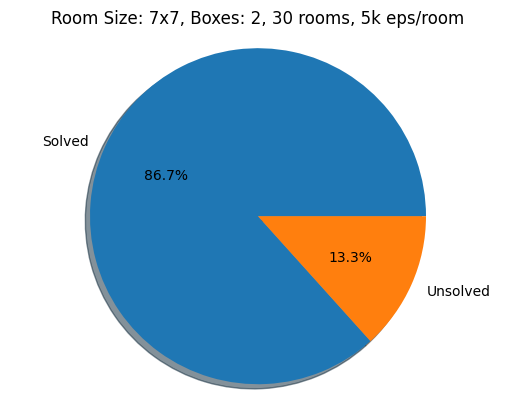

In [47]:
# pie chart of returns>0
labels = 'Solved', 'Unsolved'
sizes = [len(returns5[returns5>0]), len(returns5[returns5<0])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Room Size: 7x7, Boxes: 2, 30 rooms, 5k eps/room')
plt.show()

We can see that the DQN agent is excellent at solving these small puzzles. Compared to the MC agent we increased the performance from ~58% to ~80% solved rooms. This is a huge improvement!

Let's look at some of the agent's behavior:

| Run 1 | Run 2 | Run 3 | Run 4 | Run 5 | Run 6 |
| :---: | :---: | :---: | :---: | :---: | :---: |
| ![Run 1](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_1/video.gif?raw=true) | ![Run 2](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_2/video.gif?raw=true) | ![Run 3](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_3/video.gif?raw=true) | ![Run 4](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_4/video.gif?raw=true) | ![Run 5](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_5/video.gif?raw=true)| ![Run 6](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_6/video.gif?raw=true) |
| **Run 7** | **Run 8** | **Run 9** | **Run 10** | **Run 11** | **Run 12** |
| ![Run 7](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_7/video.gif?raw=true) | ![Run 8](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_8/video.gif?raw=true) | ![Run 9](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_9/video.gif?raw=true) | ![Run 10](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_10/video.gif?raw=true) | ![Run 11](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_11/video.gif?raw=true) | ![Run 12](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_12/video.gif?raw=true) |
| **Run 13** | **Run 14** | **Run 15** | **Run 16** | **Run 17** | **Run 18** |
| ![Run 13](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_13/video.gif?raw=true) | ![Run 14](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_14/video.gif?raw=true) | ![Run 15](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_15/video.gif?raw=true) | ![Run 16](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_16/video.gif?raw=true) | ![Run 17](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_17/video.gif?raw=true) | ![Run 18](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_18/video.gif?raw=true) |
| **Run 19** | **Run 20** | **Run 21** | **Run 22** | **Run 23** | **Run 24** |
| ![Run 19](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_19/video.gif?raw=true) | ![Run 20](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_20/video.gif?raw=true) | ![Run 21](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_21/video.gif?raw=true) | ![Run 22](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_22/video.gif?raw=true) | ![Run 23](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_23/video.gif?raw=true) | ![Run 24](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_24/video.gif?raw=true) |
| **Run 25** | **Run 26** | **Run 27** | **Run 28** | **Run 29** | **Run 30** |
| ![Run 25](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_25/video.gif?raw=true) | ![Run 26](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_26/video.gif?raw=true) | ![Run 27](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_27/video.gif?raw=true) | ![Run 28](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_28/video.gif?raw=true) | ![Run 29](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_29/video.gif?raw=true) | ![Run 30](./data/logs/DQN_experiments/small_30_avg_5k_eps/DQN_30/video.gif?raw=true) |

You can see that the difficulty of the levels varies quite a bit. Compare Run 5 and 6 for example. Run 6 is a very easy level, while Run 5 is considerably harder. Although, the agent is able to solve both of them. 

You can also see the result of failing to limit the agent to the same 4 actions as in the MC experiments. Run 2, 13 and 17 show the agent standing still for the entire episode. It is performing the action 0, which is the action to do nothing.

### 6.1.2 5k Episodes: Sokoban-v0

Now let's look at the results for the `Sokoban-v0` environment.

In [48]:
# remove line below to run cell, takes long time to run!
%%script false --no-raise-error

log_loc = "./data/logs/DQN_experiments/regular_30_avg_5k_eps/"
totsteps = 5_000 * 200 # 5k episodes per room; 200 steps per episode

env = gym.make('Sokoban-v0')
envs = []
returns = []

for i in tqdm.trange(30, desc='Training', unit='ep'):
    # create environment
    x = env.reset(keep=False)
    envs.append(x)

    # create model
    model = DQN('MlpPolicy', env, verbose=0, tensorboard_log=log_loc, exploration_initial_eps=0.25, exploration_final_eps=0.25)

    # define the evaluation callback
    # Stop training when the model reaches the reward threshold
    callback_on_best = StopTrainingOnRewardThreshold(reward_threshold=10, verbose=1)
    eval_callback = EvalCallback(env, callback_on_new_best=callback_on_best, verbose=0)

    # train model
    model.learn(total_timesteps=totsteps, callback=eval_callback, progress_bar=False)

    # evaluate model
    mean_return, _ = evaluate_policy(model, env, n_eval_episodes=1)
    returns.append(mean_return)
    print(f"mean_return: {mean_return:.2f}")
    record_agent(env, model, log_loc+f"DQN_{i+1}/video.gif")

# save envs and returns
np.save('./data/logs/DQN_experiments/DQN_regular_envs_30_avg_5k_eps.npy', envs)
np.save('./data/logs/DQN_experiments/DQN_regular_returns_30_avg_5k_eps.npy', returns)

UsageError: Line magic function `%%script` not found.


Here's a screenshot of the TensorBoard logs of this run:

<figure>
<img src=".\data\logs\DQN_experiments\regular_30_avg_5k_eps\rollout_ep_rew_mean.svg">
<figcaption align = "center"> Mean Reward During Training </figcaption>
</figure>

The majority of the runs sadly did not solve the room at all. Some did solve it, but not consistently.

So let's load the results from the experiments conducted above:

In [49]:
returns6 = np.load('./data/logs/DQN_experiments/DQN_regular_returns_30_avg_5k_eps.npy')
envs6 = np.load('./data/logs/DQN_experiments/DQN_regular_envs_30_avg_5k_eps.npy')

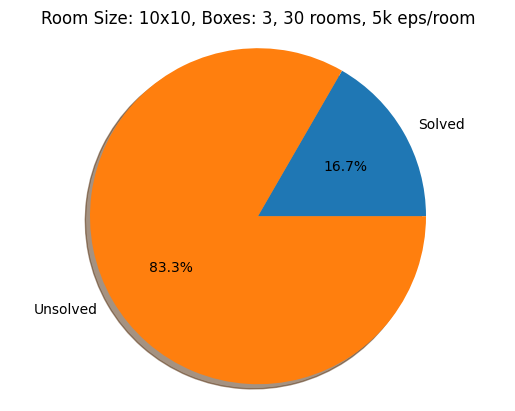

In [50]:
# pie chart of returns>0
labels = 'Solved', 'Unsolved'
sizes = [len(returns6[returns6>0]), len(returns6[returns6<0])]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Room Size: 10x10, Boxes: 3, 30 rooms, 5k eps/room')
plt.show()

Unsurprisingly it is quite worse than the smaller room variant. But it still improves compared to the MC experiments, which is a good sign.

Let's look at the agents performance on the `Sokoban-v0` environment:

| Run 1 | Run 2 | Run 3 | Run 4 | Run 5 | Run 6 |
| :---: | :---: | :---: | :---: | :---: | :---: |
| ![Run 1](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_1/video.gif?raw=true) | ![Run 2](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_2/video.gif?raw=true) | ![Run 3](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_3/video.gif?raw=true) | ![Run 4](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_4/video.gif?raw=true) | ![Run 5](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_5/video.gif?raw=true)| ![Run 6](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_6/video.gif?raw=true) |
| **Run 7** | **Run 8** | **Run 9** | **Run 10** | **Run 11** | **Run 12** |
| ![Run 7](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_7/video.gif?raw=true) | ![Run 8](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_8/video.gif?raw=true) | ![Run 9](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_9/video.gif?raw=true) | ![Run 10](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_10/video.gif?raw=true) | ![Run 11](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_11/video.gif?raw=true) | ![Run 12](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_12/video.gif?raw=true) |
| **Run 13** | **Run 14** | **Run 15** | **Run 16** | **Run 17** | **Run 18** |
| ![Run 13](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_13/video.gif?raw=true) | ![Run 14](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_14/video.gif?raw=true) | ![Run 15](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_15/video.gif?raw=true) | ![Run 16](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_16/video.gif?raw=true) | ![Run 17](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_17/video.gif?raw=true) | ![Run 18](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_18/video.gif?raw=true) |
| **Run 19** | **Run 20** | **Run 21** | **Run 22** | **Run 23** | **Run 24** |
| ![Run 19](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_19/video.gif?raw=true) | ![Run 20](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_20/video.gif?raw=true) | ![Run 21](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_21/video.gif?raw=true) | ![Run 22](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_22/video.gif?raw=true) | ![Run 23](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_23/video.gif?raw=true) | ![Run 24](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_24/video.gif?raw=true) |
| **Run 25** | **Run 26** | **Run 27** | **Run 28** | **Run 29** | **Run 30** |
| ![Run 25](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_25/video.gif?raw=true) | ![Run 26](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_26/video.gif?raw=true) | ![Run 27](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_27/video.gif?raw=true) | ![Run 28](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_28/video.gif?raw=true) | ![Run 29](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_29/video.gif?raw=true) | ![Run 30](./data/logs/DQN_experiments/regular_30_avg_5k_eps/DQN_30/video.gif?raw=true) |

These runs are considerably harder than the previous smaller rooms. You can see that the agent sometimes comes close to solving a room but then gets stuck in a local minimum (see Run 2 or 26 for example). This is probably due to not training enough episodes per room, which we couldn't do in this submission due to time constraints. 

## 6.2 Results <a id="dqnresults"></a> 

By choosing a more fitting algorithm for large state space, we improved our performance in both settings:

% of rooms solved:
| environment | MC 5k | DQN 5k |
|------------|-------|--------|
| `Sokoban-small-v0`   | 58.3% | 86.7%  |
| `Sokoban-v0` |  6.7% | 16.7%  |

We can clearly see an improved performance of the DQN agents as compared to MC. Note that the DQN agent still was handicapped by the fact that we did not limit its action space the same way we did for MC. We believe that this would have improved the performance even further.

Further improvements could be made by training the DQN agent for more episodes per room. We believe that this would have also improved the performance even further, the same way it did for the MC agent.

Also, some hyperparameter tuning could have been done to improve the performance of the DQN agent.

# 7 Conclusion <a id="conclusion"></a>

[🔝 Return to Table of Contents](#toc)

This project showed how different RL algorithms can be applied to the [Sokoban environment](https://github.com/mpSchrader/gym-sokoban). We showed that the performance of the algorithms depends on the size of the state space and the complexity of the environment. While the true crux of the problem is to seamlessly adapt to unseen rooms, we also got relevant insights by limiting the agents to a single room.

We found that the Monte Carlo algorithm is a good choice for small state spaces, but that it quickly becomes infeasible for larger state spaces. The DQN algorithm on the other hand is a good choice for large state spaces, but it is not as runtime efficient as Monte Carlo.

The methods showcased on this exemplary Sokoban problem can be applied to more realistic scenarios in the domain of warehousing. The algorithms can be used to optimize the movement of robots in a warehouse, which can lead to a more efficient use of time and energy.

# Post-Submission Notes

Fixing the DQN's action space can be done like this:

In [ ]:
from gym.spaces import Discrete

class CustomActionSpace(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.action_space = Discrete(4)  # limit action space to 4 actions

    def action(self, act):
        # map actions actions 0, 1, 2, and 3 to 1, 2, 3, and 4
        return act + 1
    
env = gym.make('Sokoban-v0')
env = CustomActionSpace(env)

# References <a id="references"></a>

[🔝 Return to Table of Contents](#toc)

[1] GitHub: [M. P. Schrader, *Gym-Sokoban*](https://github.com/mpSchrader/gym-sokoban)

[2] Wikipedia: [*Permutation of Multisets*](https://en.wikipedia.org/wiki/Permutation#Permutations_of_multisets)

[3] Paper: [Weber et al., *Imagination-Augmented Agents for Deep Reinforcement Learning*](https://arxiv.org/pdf/1707.06203.pdf)

[4] Video: [Interesting Engineering, *Warehouse robots that are reshaping the industry*](https://www.youtube.com/watch?v=LDhJ5I89H_I)

[5] Book: [R. S. Sutton and A. G. Barto, *Reinforcement Learning: An Introduction*](https://mitpress.mit.edu/9780262039246/reinforcement-learning/)

[6] Paper: [Mnih et al., *Playing Atari with Deep Reinforcement Learning*](https://arxiv.org/pdf/1312.5602.pdf)